<a href="https://colab.research.google.com/github/miranda-bi/CHL5230-Datathon/blob/main/Datathon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')

# Part 1: Factors that affect likelihood of getting heart disease

In [ ]:
from google.colab import files
uploaded = files.upload()

# Import necessary libraries
import pandas as pd
import io

# Read the dataset into a Pandas DataFrame
#df = pd.read_csv('Cardiovascular Event Dataset.csv')
df = pd.read_csv(io.BytesIO(uploaded['Cardiovascular Event Dataset.csv']))


# Inspect the first five rows of the data
df.head()

Saving Cardiovascular Event Dataset.csv to Cardiovascular Event Dataset.csv


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
#Move heart disease column to end
df.insert(len(df.columns)-1, 'heart_disease', df.pop('heart_disease'))

df.head()

,id,gender,age,hypertension,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,heart_disease
0,9046,Male,67.0,0,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1
1,51676,Female,61.0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,0
2,31112,Male,80.0,0,Yes,Private,Rural,105.92,32.5,never smoked,1,1
3,60182,Female,49.0,0,Yes,Private,Urban,171.23,34.4,smokes,1,0
4,1665,Female,79.0,1,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,0


In [ ]:
# Count of heart disease outcome - limitation in that there was bias in data
print((df['heart_disease']==0).sum())
print((df['heart_disease']==1).sum())

4834
276


In [ ]:
# Check for missing values in each column
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
heart_disease          0
dtype: int64


In [ ]:
#Fill in nan values with the median
df.fillna(df.median(), inplace=True)

In [ ]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # Female: 0, Male: 1, Other: 2
df['ever_married'] = le.fit_transform(df['ever_married'])
df['work_type'] = le.fit_transform(df['work_type'])
df['Residence_type'] = le.fit_transform(df['Residence_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])

df.head()

,id,gender,age,hypertension,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,heart_disease
0,9046,1,67.0,0,1,2,1,228.69,36.6,1,1,1
1,51676,0,61.0,0,1,3,0,202.21,28.1,2,1,0
2,31112,1,80.0,0,1,2,0,105.92,32.5,2,1,1
3,60182,0,49.0,0,1,2,1,171.23,34.4,3,1,0
4,1665,0,79.0,1,1,3,0,174.12,24.0,2,1,0


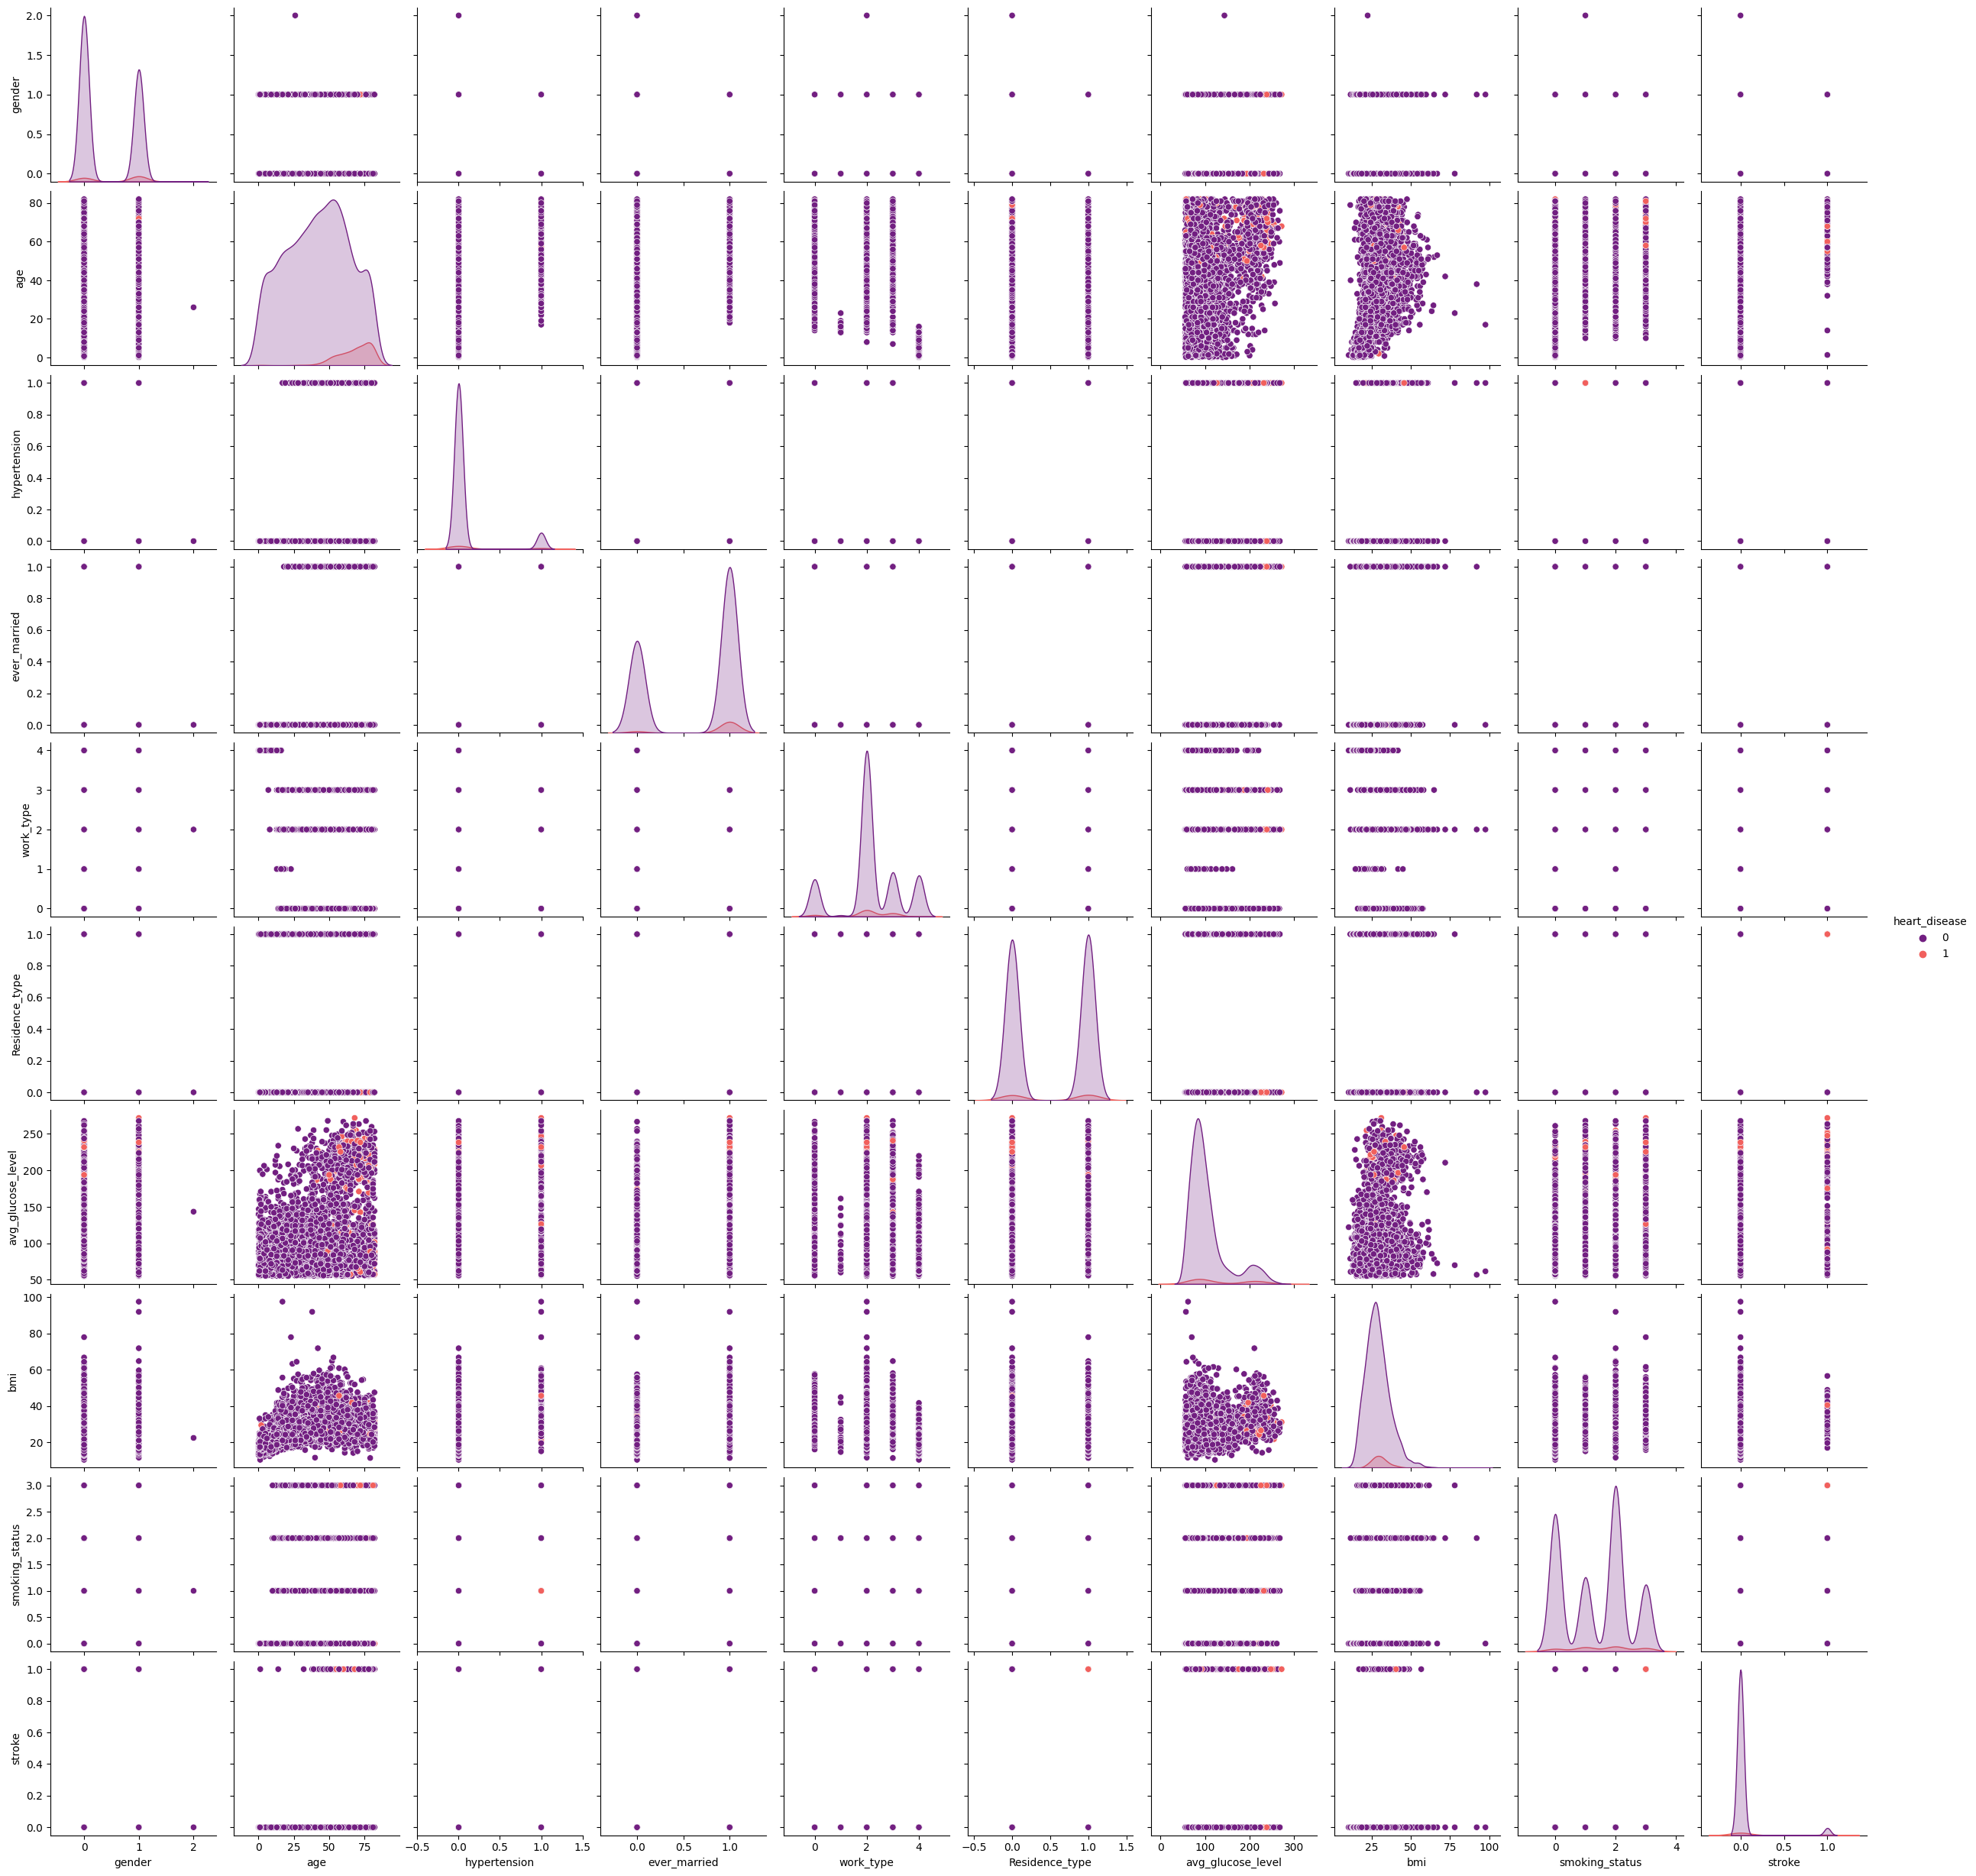

In [ ]:
# Display pair plot for data visualization
# Use iloc to remove 'id' since it's not an actual feature
sns.pairplot(df.iloc[:,1:len(df.columns)], hue='heart_disease', palette="magma")
plt.show()

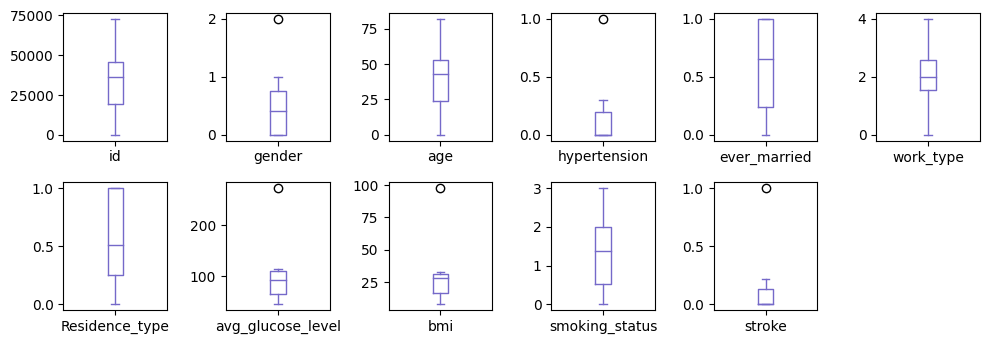

In [ ]:
description = df.describe()
# Drop the 'count' row for better visualization
description = description.drop('count')
description = description.drop('heart_disease', axis=1)
# Visual representation of data.describe()
description.plot(kind='box', subplots=True, layout=(3, 6), figsize=(10, 5), color='#7569c9')
plt.tight_layout()
plt.show()

,id,gender,age,hypertension,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,heart_disease
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,0.414286,43.226614,0.097456,0.656164,2.167710,0.508023,106.147677,28.893237,1.376908,0.048728,0.054012
std,21161.721625,0.493044,22.612647,0.296607,0.475034,1.090293,0.499985,45.283560,7.854067,1.071534,0.215320,0.226063
min,67.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000
25%,17741.250000,0.000000,25.000000,0.000000,0.000000,2.000000,0.000000,77.245000,23.500000,0.000000,0.000000,0.000000
50%,36932.000000,0.000000,45.000000,0.000000,1.000000,2.000000,1.000000,91.885000,28.100000,2.000000,0.000000,0.000000
75%,54682.000000,1.000000,61.000000,0.000000,1.000000,3.000000,1.000000,114.090000,33.100000,2.000000,0.000000,0.000000
max,72940.000000,2.000000,82.000000,1.000000,1.000000,4.000000,1.000000,271.740000,97.600000,3.000000,1.000000,1.000000


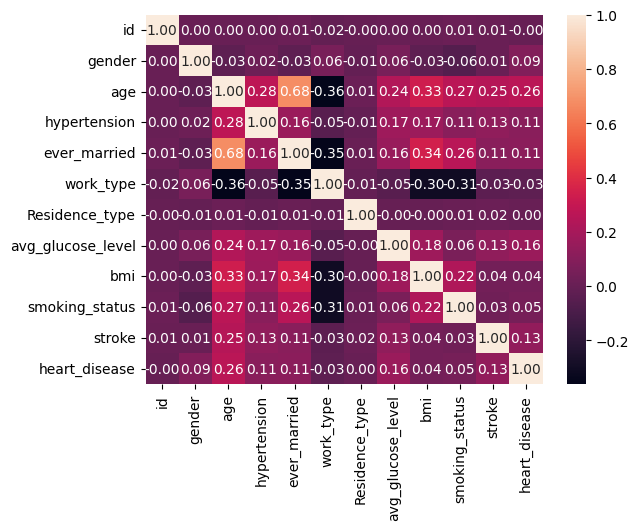

In [ ]:
# Correlation matrix to quantify relationships
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

# Summary statistics
df.describe()

In [ ]:
# Split the data into features and target variable
X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Training logistic regression model
log_reg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
log_reg.fit(X_train, y_train)

# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# The penalty parameter is used to specify the norm used in the penalization: l1 or l2 regularization.
# The C parameter represents inverse of regularization strength, smaller values specify stronger regularization.
# The solver parameter specifies the algorithm to use in the optimization problem.


Confusion Matrix:
[[1928    8]
 [ 106    2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1936
           1       0.20      0.02      0.03       108

    accuracy                           0.94      2044
   macro avg       0.57      0.51      0.50      2044
weighted avg       0.91      0.94      0.92      2044



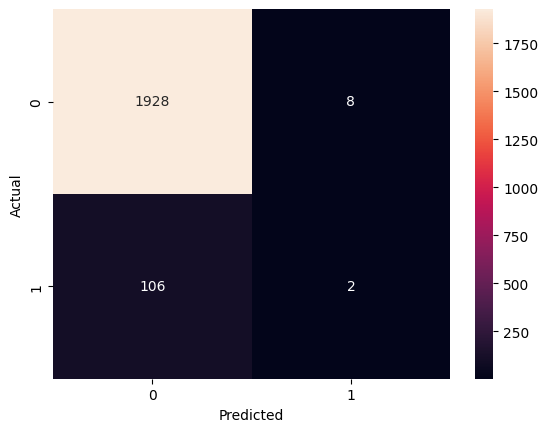

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

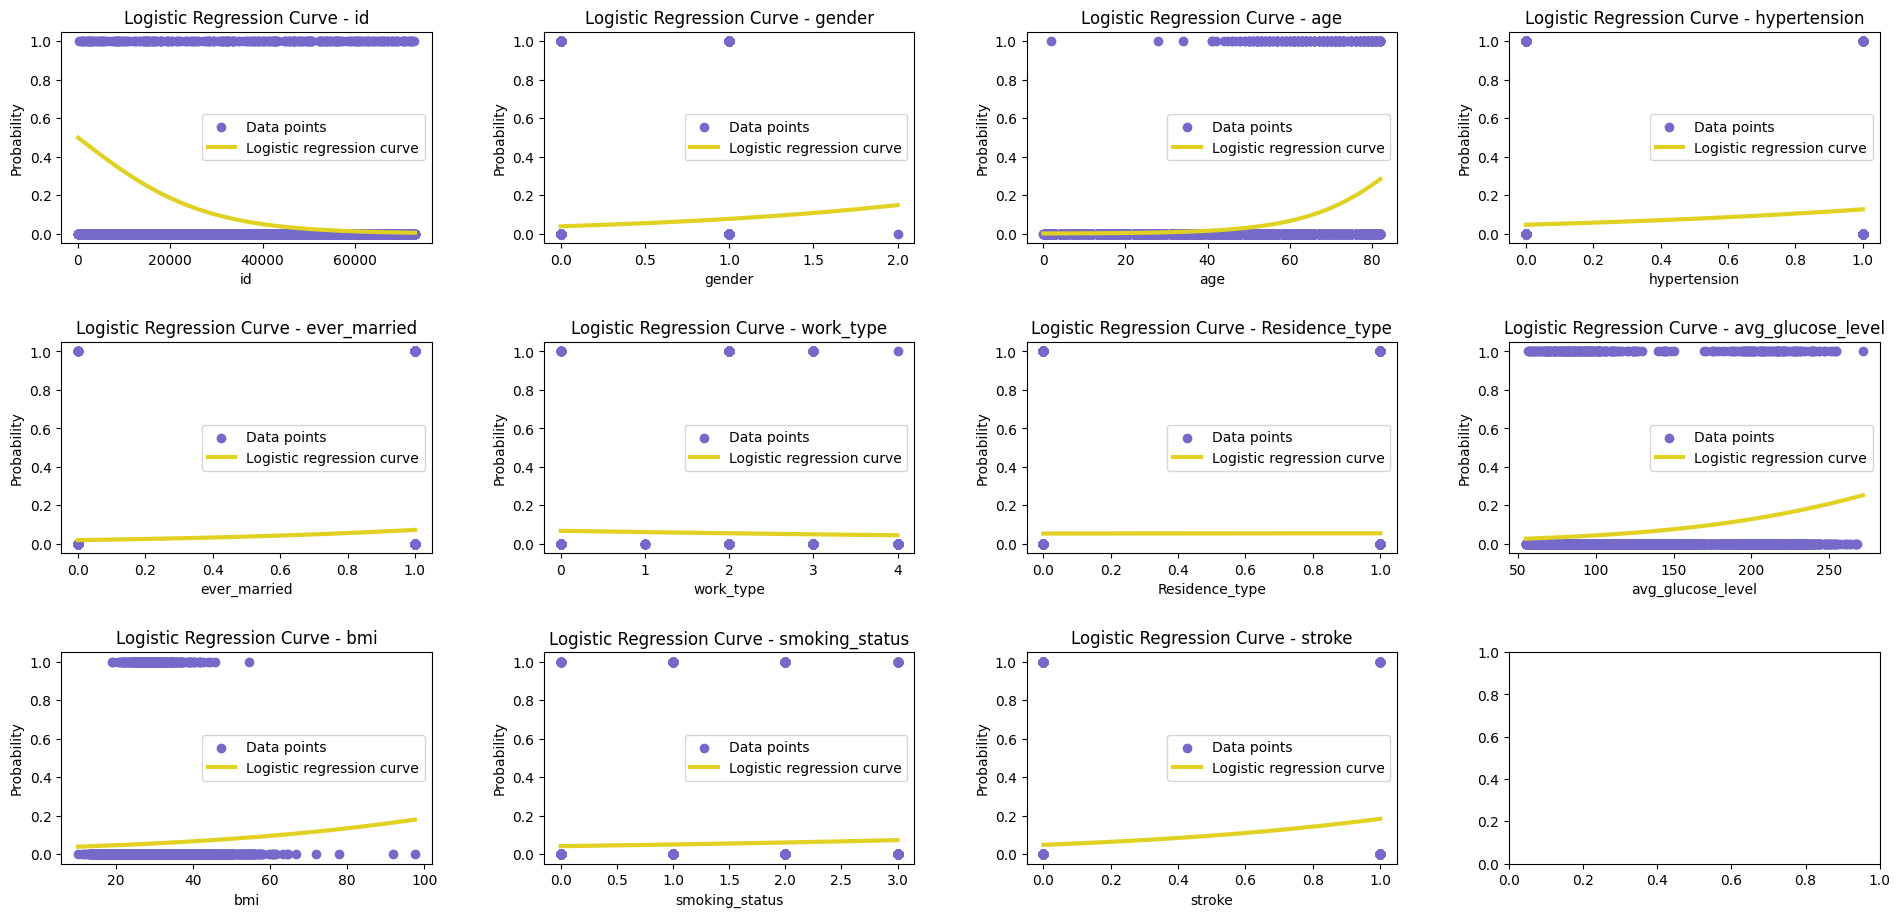

In [ ]:
# Create logistic regression object
log_reg = LogisticRegression()

fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.tight_layout(pad=5.0)  # Adds padding between subplots

for i, feature in enumerate(df.columns[:-1]):  # Exclude 'Outcome' column
    row = i // 4  # Determine row index
    col = i % 4   # Determine column index

    # Reshape the feature and outcome arrays to fit the model
    X = df[[feature]]
    y = df['heart_disease']

    # Fit logistic regression model
    log_reg.fit(X, y)

    # Get min and max values of the feature for plotting
    x_test = np.linspace(X.min(), X.max(), 300)

    # Get the probability for each value in the range
    prob = log_reg.predict_proba(x_test)[:, 1]

    # Plot the data points
    axs[row, col].scatter(X, y, color='#7569c9', label='Data points')

    # Plot the sigmoid curve
    axs[row, col].plot(x_test, prob, color='#e0d122', lw=3, label='Logistic regression curve' )

    axs[row, col].set_title(f'Logistic Regression Curve - {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Probability')
    axs[row, col].legend()

plt.show()



In [ ]:
import statsmodels.api as sm
import pandas as pd

# Separate features and target variable
X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.159737
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          heart_disease   No. Observations:                 5110
Model:                          Logit   Df Residuals:                     5098
Method:                           MLE   Df Model:                           11
Date:                Sun, 01 Oct 2023   Pseudo R-squ.:                  0.2399
Time:                        05:47:59   Log-Likelihood:                -816.26
converged:                       True   LL-Null:                       -1073.9
Covariance Type:            nonrobust   LLR p-value:                1.708e-103
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -8.2726      0.575    -14.382      0.000      -9.400      -7.145
id      

**K Means algorithm**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)  # Setting K to 5 as an example
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

In [ ]:
# Required libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Function to visualize the clustering results
def plot_clusters(x, labels, k):
    # Define colors for each cluster
    colors = ['#860991', '#d6ba2f', '#c4c1b3']
    # Loop through each cluster
    for i in range(k):
        # Filter the data points that belong to the current cluster
        filtered_label0 = x[labels == i]
        # Plot the filtered data points using the corresponding color
        plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], c=colors[i])
    # Display the plot
    plt.show()

# Choose two features for clustering and visualization
features = ['gender', 'age','hypertension', 'work_type', 'heart_disease']

# Convert the selected features from DataFrame to a NumPy array for easier processing with sklearn
data =  df[features].to_numpy()

# Standardize the data - this makes the mean 0 and standard deviation 1 for each feature
# Standardization can help the k-means algorithm perform better as it's sensitive to feature scales
st_x = StandardScaler()
data = st_x.fit_transform(data)

# Apply k-means clustering on the standardized data
# Here, we're specifying 3 clusters with a fixed random state for reproducibility
kmeans = KMeans(n_clusters=2, random_state=0)
label = kmeans.fit_predict(data)

# Visualize the clustering results using the defined function
plot_clusters(data, label, 2)

# Part 2: Patterns Within Patients with Heart Disease

In [ ]:
from google.colab import files
uploaded = files.upload()

# Import necessary libraries
import pandas as pd
import io

# Read the dataset into a Pandas DataFrame
#df2 = pd.read_csv('Mortality Dataset.csv')
df2 = pd.read_csv(io.BytesIO(uploaded['Mortality Dataset.csv']))


# Inspect the first five rows of the data
df2.head()

Saving Mortality Dataset.csv to Mortality Dataset.csv


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
print(df2.isnull().sum())

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


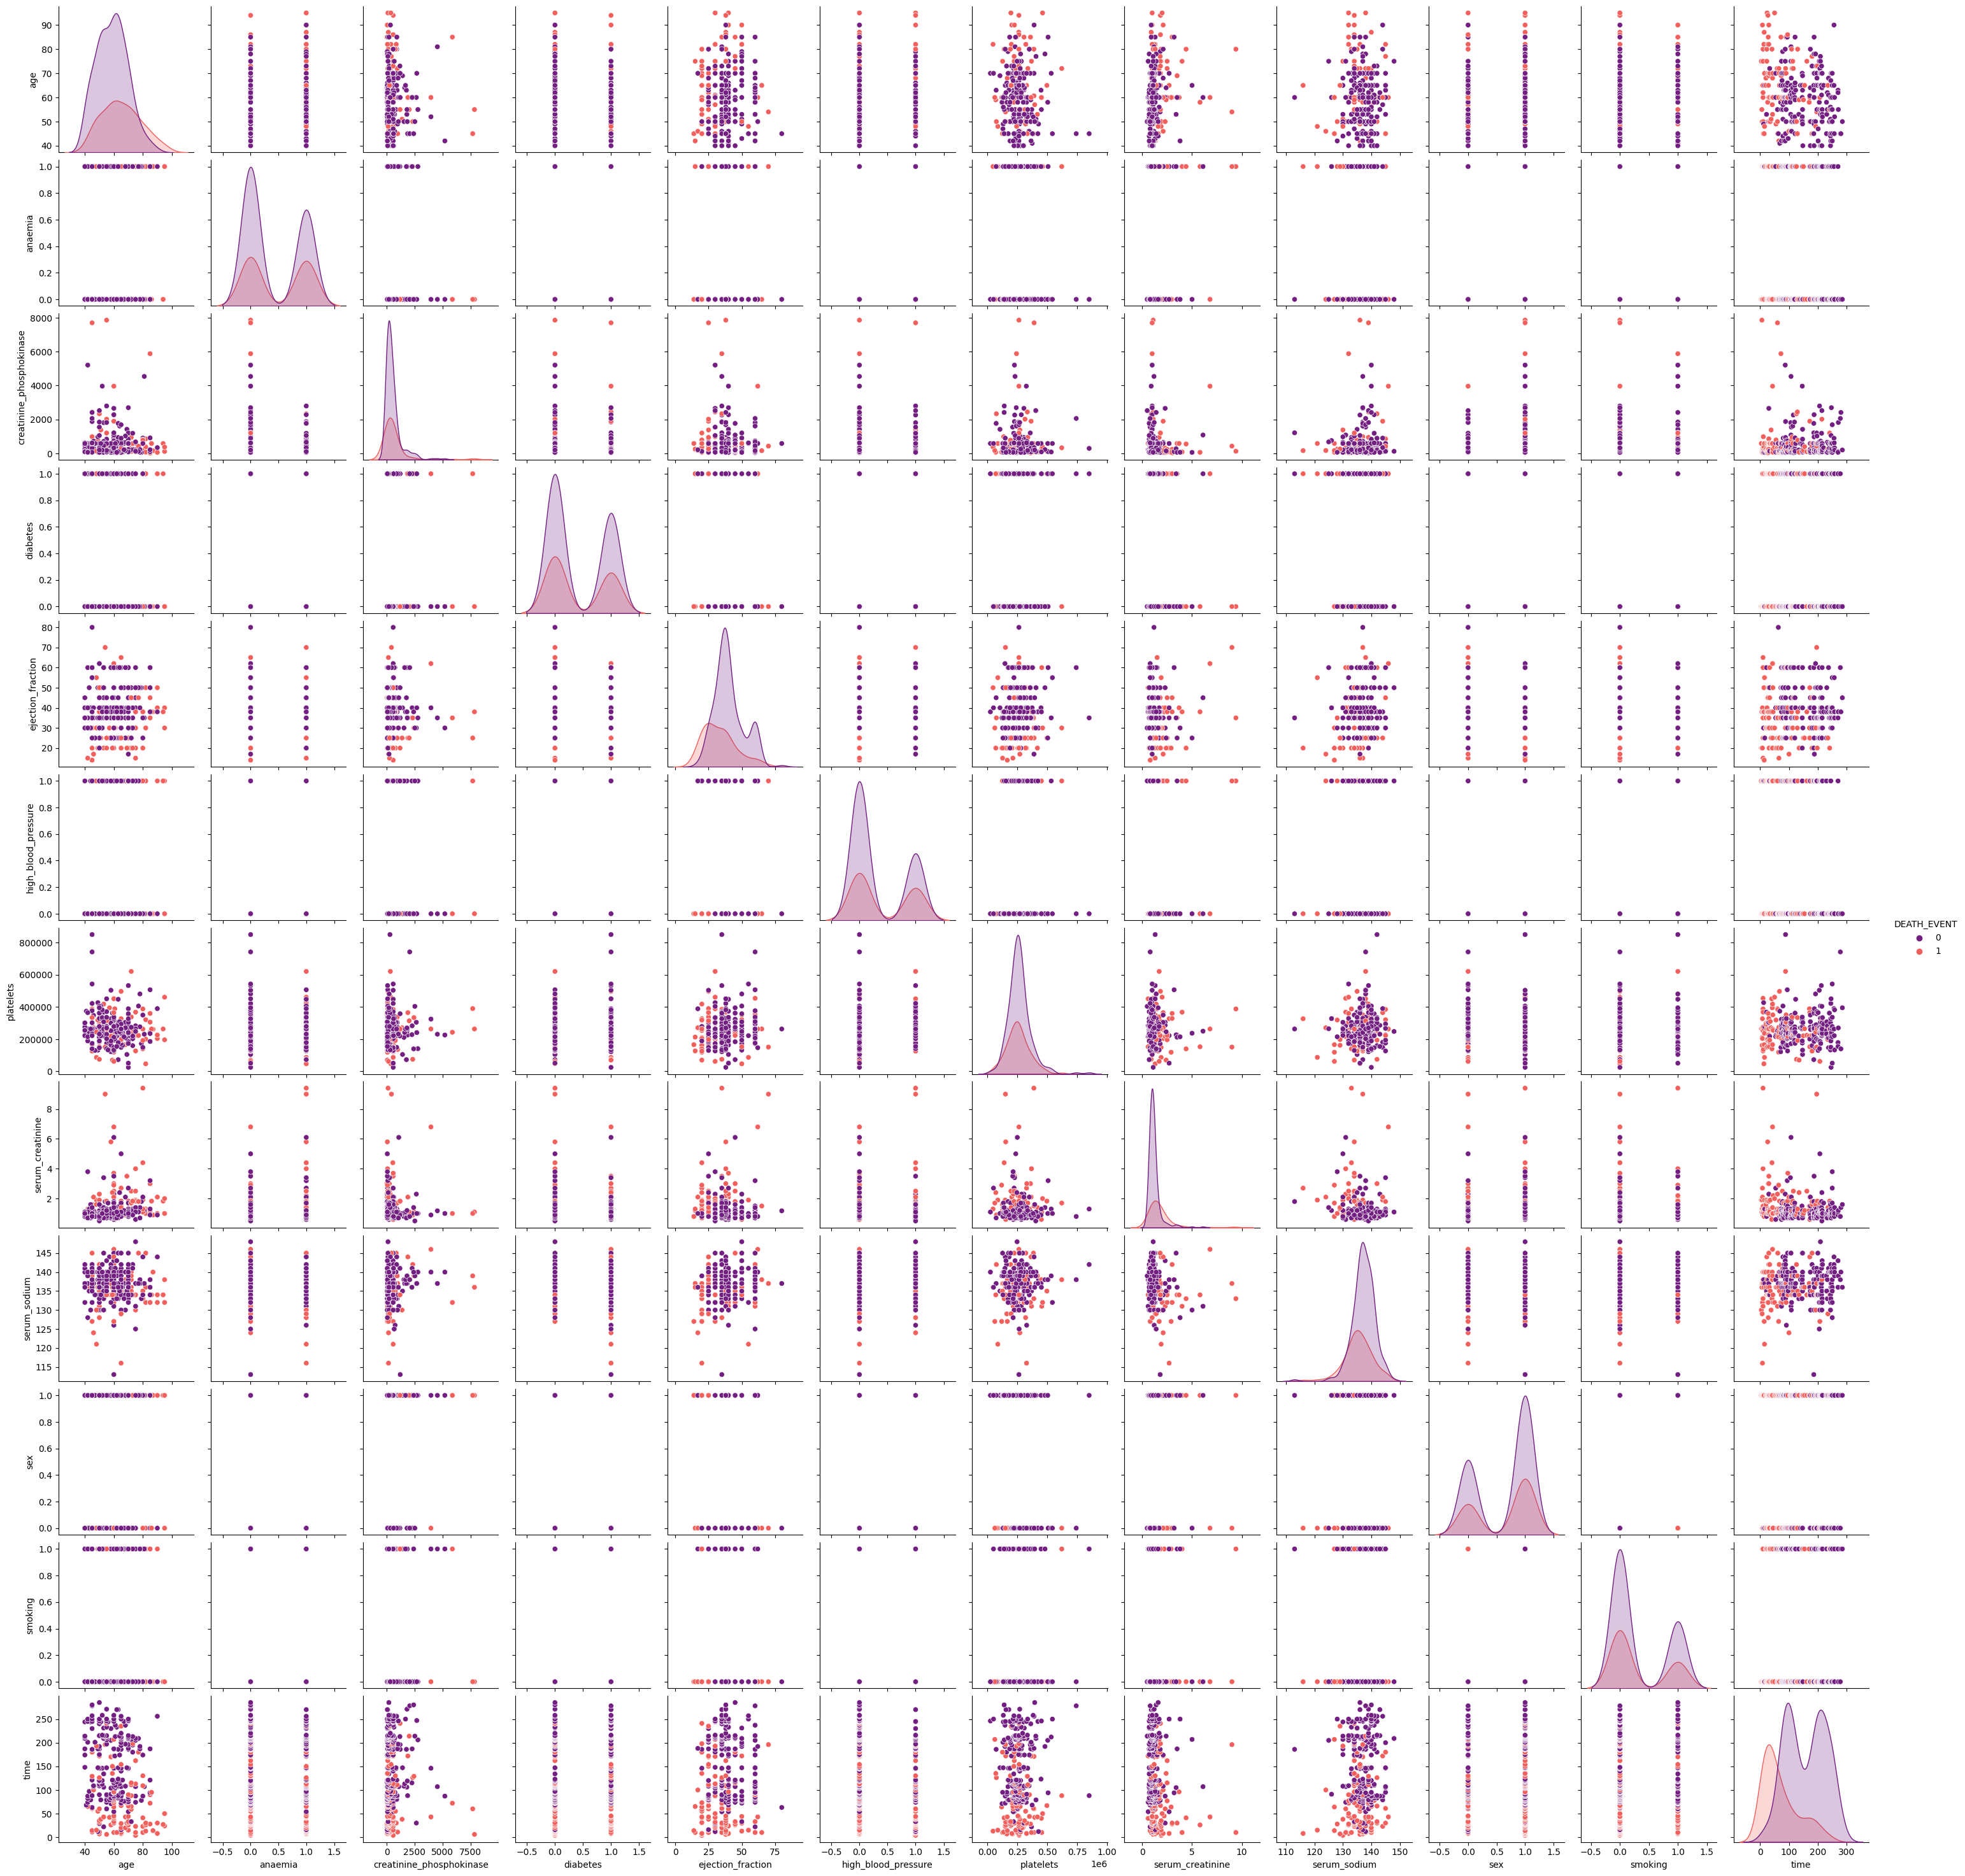

In [ ]:
# Display pair plot for data visualization
# Use iloc to remove 'id' since it's not an actual feature
sns.pairplot(df2, hue='DEATH_EVENT', palette="magma")
plt.show()

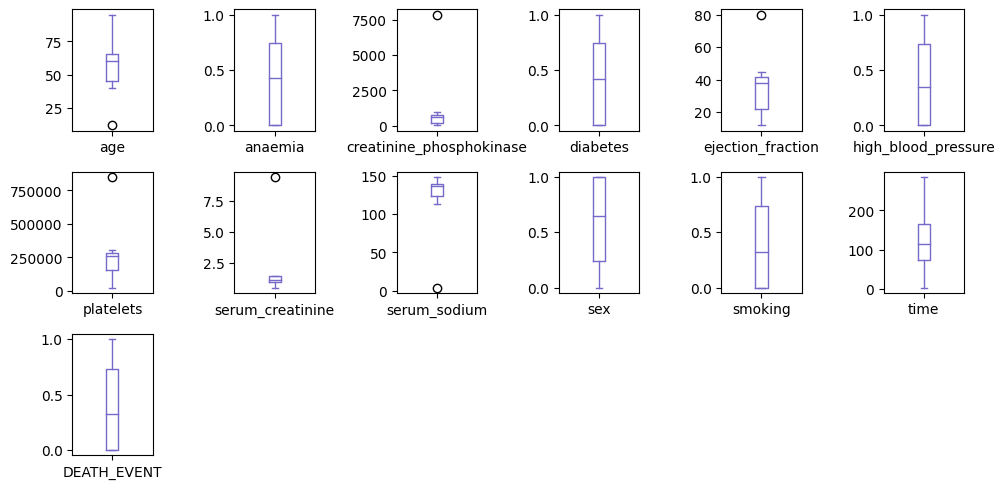

In [ ]:
description = df2.describe()
# Drop the 'count' row for better visualization
description = description.drop('count')
#description = description.drop('DEATH_EVENT', axis=1)
# Visual representation of data.describe()
description.plot(kind='box', subplots=True, layout=(3, 6), figsize=(10, 5), color='#7569c9')
plt.tight_layout()
plt.show()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


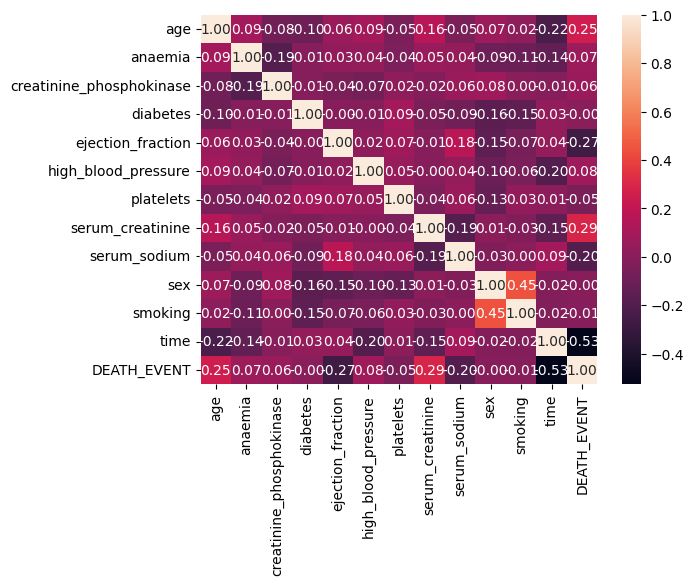

In [ ]:
# Correlation matrix to quantify relationships
corr_matrix2 = df2.corr()
sns.heatmap(corr_matrix2, annot=True, fmt=".2f")

# Summary statistics
df2.describe()

Text(0.5, 0, 'k')

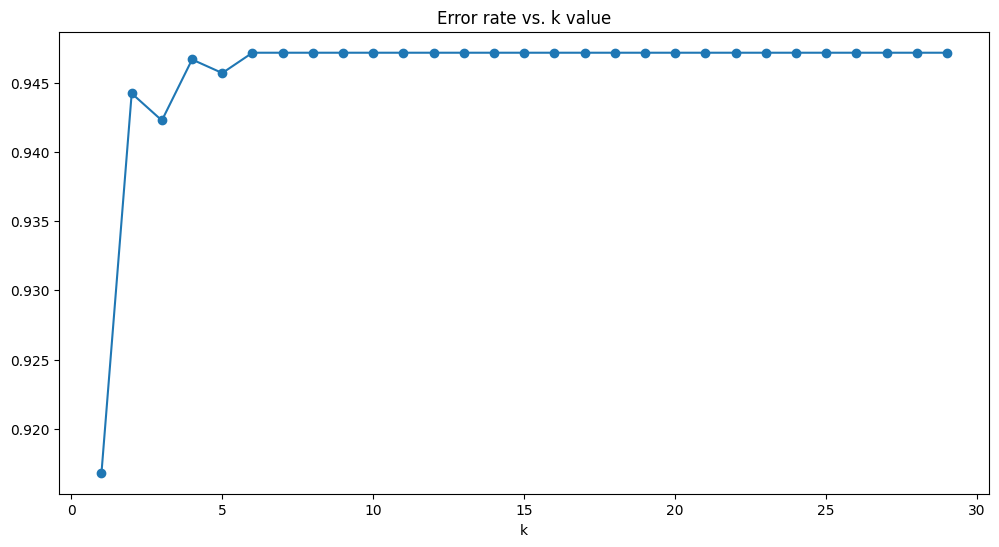

In [ ]:
# Import libraries necessary
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

# Apply elbow method
k_values=range(1, 30)
errors=[]

for k in k_values:

  knn=KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train,y_train)
  y_pred=knn.predict(X_test)
  error=accuracy_score(y_test,y_pred)
  errors.append(error)

# Plot the elbow method
plt.figure(figsize=(12,6))
plt.plot(k_values,errors,marker="o")
plt.title("Error rate vs. k value")
plt.xlabel("k")

#To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after
#which the plot starts decreasing in a linear fashion.
#Thus for the given data, we conclude that the optimal number of clusters for the data is 3.
#K=3 not overfitting


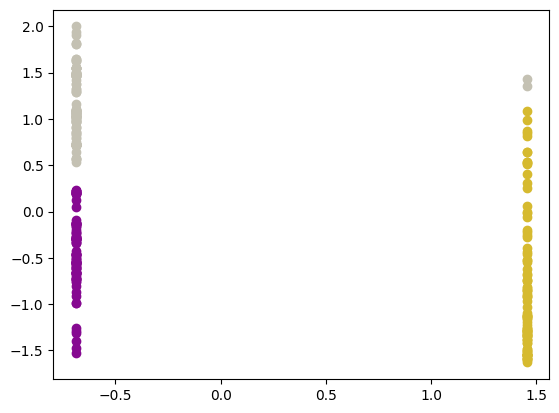

In [ ]:
# Required libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Function to visualize the clustering results
def plot_clusters(x, labels, k):
    # Define colors for each cluster
    colors = ['#860991', '#d6ba2f', '#c4c1b3']
    # Loop through each cluster
    for i in range(k):
        # Filter the data points that belong to the current cluster
        filtered_label0 = x[labels == i]
        # Plot the filtered data points using the corresponding color
        plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], c=colors[i])
    # Display the plot
    plt.show()

# Choose two features for clustering and visualization
# Observed visually different clusters for time and the following variables:
# ejection_fraction, platelets, serum_creatinine, serum_sodium, creatinine_phosphokinase, age
features = ['DEATH_EVENT', 'time']

# Convert the selected features from DataFrame to a NumPy array for easier processing with sklearn
data =  df2[features].to_numpy()

# Standardize the data - this makes the mean 0 and standard deviation 1 for each feature
# Standardization can help the k-means algorithm perform better as it's sensitive to feature scales
st_x = StandardScaler()
data = st_x.fit_transform(data)

# Apply k-means clustering on the standardized data
# Here, we're specifying  clusters with a fixed random state for reproducibility
kmeans = KMeans(n_clusters=3, random_state=0)
label = kmeans.fit_predict(data)

# Visualize the clustering results using the defined function
plot_clusters(data, label, 3)